In [86]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.model_selection import cross_val_score, ShuffleSplit
from scipy.stats import shapiro
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from sklearn.preprocessing import quantile_transform
from statsmodels.graphics.gofplots import qqplot_2samples
from statsmodels.graphics.factorplots import interaction_plot
from scipy.stats import boxcox, f_oneway
from scipy.stats.mstats import kruskalwallis
from pingouin import welch_anova
import random

import seaborn as sns
import scipy.stats as stats
sns.set(style='darkgrid')

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## 1. Максимум статистики Краскелла-Уоллиса

Пусть у нас есть k выборок размера $n_1, \dots, n_k$. Общее количество наблюдаемых объектов N, ранки объектов r_1, \dots, r_N.

Выпишем статистику Краскелла-Уоллиса:
    
$$H = \dfrac{12}{N(N+1)} \sum_{i=1}^k n_i\left(\overline{r_i} - \dfrac{N+1}{2}\right)^2 = \dfrac{12}{N(N+1)} \sum_{i=1}^k n_i\overline{r_i}^2 - 3(N+1)$$

Хотим максимизировать H, при фиксированных $n_1, \dots, n_k$

$H \to max \Leftrightarrow \sum_{i=1}^k n_i\overline{r_i}^2 \to max$


$$\sum_{i=1}^k n_i\overline{r_i}^2  = \sum_{i=1}^k n_i \left(\dfrac{\sum_{j=1}^{n_i} r_{ji}}{n_i}\right)^2 =  \sum_{i=1}^k \dfrac{(\sum_{j=1}^{n_i} r_{ij})^2}{n_i}$$


Так как статистика хочет проверить, из одного ли распределения у нас выборки (чем больше значение статистики, тем вероятнее, что не из одного), то кажется, что самое большое значение она должна принимать, когда выборки разделимы по рангам  e.g. для k=2, $n_1 = 3, n_2=2:$ выборка 1: 1, 2, 3, выборка 2: 4 5 
       

Покажем это:

> Пусть у нас есть фиксированный набор $n_1, \dots n_k$ и $r_1, \dots, r_N$ и наблюдаемые объекты как-то распределены по выборкам $1, \dots, k$. Пусть есть две выборки с суммами рангов $R_{a}, R_{b}$ и элементами с рангами $r_a < r_b$, тогда если $\dfrac{R_a}{n_a} > \dfrac{R_b}{n_b}$, то если свопнуть местами элементы соответствующие $r_a, r_b$ в выборках, то значение статистики увеличится

Введем $H'= \sum_{i=1}^k \dfrac{(\sum_{j=1}^{n_i} r_{ji})^2}{n_i}$, так как мы хотим задействовать только две выборки, то изменится только часть, соответствующая им: $\dfrac{(\sum_{j=1}^{n_a} r_{aj})^2}{n_a} + \dfrac{(\sum_{j=1}^{n_b} r_{bj})^2}{n_b} = \dfrac{R_a^2}{n_a} + \dfrac{R_b^2}{n_b}$


Пусть $r = r_b - r_a > 0$

Тогда интересующая нас сумма будет выглядеть так: $\dfrac{(R_a + r)^2}{n_a} + \dfrac{(R_b - r)^2}{n_b}$

Проверим, что такой своп действительно увеличивает значение статистики: $\dfrac{(R_a + r)^2}{n_a} + \dfrac{(R_b - r)^2}{n_b} = \dfrac{R_a^2}{n_a} + \dfrac{R_b^2}{n_b} = \dfrac{2R_ar + r^2}{n_a} + \dfrac{r^2 - 2R_br}{n_b} = \dfrac{r^2(n_a + n_b)}{n_an_b} + 2r \left(\dfrac{R_a}{n_a} - \dfrac{R_b}{n_b}\right) > 0$

Такими свопами мы как раз и придем к рангам, отсорченным по выборкам. Теперь посчитаем значение статистики в такой ситуации (тут сложновато). Хотим считать суммы рангов внутри выборки j как арифметическую прогрессию: первый элемент $(\sum_{s=1}^{j-1}n_s) + 1$, последний: $\sum_{s=1}^{j}n_s$, количество элементов $n_j$. Тогда сумма одной прогрессии $\dfrac{(2 \cdot \sum_{s=1}^{j-1}n_s + 1 + n_j)n_j}{2}$

$H' = \sum_{j = 1}^k \dfrac{(2 \cdot \sum_{s=1}^{j-1}n_s + 1 + n_j)^2n_j}{4}$

$H = \dfrac{12}{N(N+1)}\sum_{j = 1}^k \dfrac{(2 \cdot \sum_{s=1}^{j-1}n_s + 1 + n_j)^2n_j}{4} - 3(N + 1)$

Например, если все $n_i = 1

H = \dfrac{12}{N(N+1)}\sum_{j = 1}^N \dfrac{(2 \cdot \sum_{s=1}^{j-1}1 + 1 + 1)^2\cdot 1}{4} - 3(N + 1) = \dfrac{12}{N(N+1)}\sum_{j = 1}^N \dfrac{(2 (j - 1) + 1 + 1)^2}{4} - 3(N + 1) = \dfrac{12}{N(N+1)}\sum_{j = 1}^N j^2 - 3(N + 1) = \dfrac{12}{N(N+1)} \dfrac{N(N+1)(2N+1)}{6} - 3(N+1) = 4N + 2 - 3N - 3 = N - 1 $


# 2. Фигурное катание

In [5]:
data = pd.read_csv('/Users/arinaruck/Desktop/cs/ml/hw/figure_skating.csv')
data.head()

,Rank,Athlete,Result,Notes
0,G,Adelina SOTNIKOVARUS,224.59,NaN
1,S,Yuna KIMKOR,219.11,NaN
2,B,Carolina KOSTNERITA,216.73,NaN
3,4,Gracie GOLDUSA,205.53,NaN
4,5,Yulia LIPNITSKAYARUS,200.57,NaN


In [6]:
data.drop(columns=['Notes'], inplace=True)

In [7]:
res = data['Result']

In [8]:
qt_uniform = quantile_transform(res.values.reshape(-1, 1).copy(), n_quantiles=100)
qt_normal = quantile_transform(res.values.reshape(-1, 1).copy(), n_quantiles=100, output_distribution="normal")
box_cox, _ = boxcox(res)

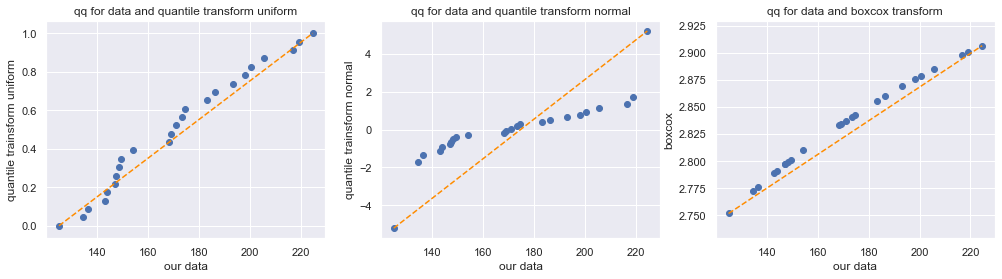

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(17, 4))
min_y, max_y = res.min(), res.max()

axes[0].scatter(res, qt_uniform);
axes[0].plot([min_y, max_y], [qt_uniform.min(), qt_uniform.max()], '--', color='darkorange')
axes[0].set_title('qq for data and quantile transform uniform')
axes[0].set_xlabel('our data')
axes[0].set_ylabel('quantile trainsform uniform');

axes[1].scatter(res, qt_normal);
axes[1].plot([min_y, max_y], [qt_normal.min(), qt_normal.max()], '--', color='darkorange')
axes[1].set_title('qq for data and quantile transform normal')
axes[1].set_xlabel('our data')
axes[1].set_ylabel('quantile trainsform normal');

axes[2].scatter(res, box_cox);
axes[2].plot([min_y, max_y],  [box_cox.min(), box_cox.max()], '--', color='darkorange')
axes[2].set_title('qq for data and boxcox transform')
axes[2].set_xlabel('our data')
axes[2].set_ylabel('boxcox');

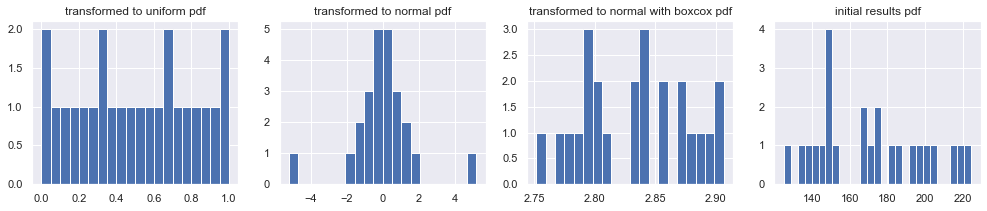

In [10]:
fig, axes = plt.subplots(1, 4, figsize=(17, 3))

axes[0].hist(qt_uniform, bins=20)
axes[0].set_title('transformed to uniform pdf')

axes[1].hist(qt_normal, bins=20)
axes[1].set_title('transformed to normal pdf')

axes[2].hist(box_cox, bins=20)
axes[2].set_title('transformed to normal with boxcox pdf')

axes[3].hist(res, bins=27)
axes[3].set_title('initial results pdf');

In [207]:
print("statistic, p-value:")
print("original data:", shapiro(res))
print("quantile normal transform:", shapiro(qt_normal))
print("quantile uniform transform:", shapiro(qt_uniform))
print("box cox:", shapiro(box_cox))
print("quantile normal transform, outliers cleaned:", shapiro(sorted(qt_normal)[1:-1]))
print("quantile normal transform, outliers cleaned:", shapiro(sorted(qt_normal)[1:-1]))
print("quantile uniform transform, a lot of samples:", shapiro(
    quantile_transform(stats.norm.rvs(size=100).reshape(-1, 1), n_quantiles=100)))
print("quantile normal transform, a lot of samples:", shapiro(
    quantile_transform(stats.uniform.rvs(size=1000).reshape(-1, 1), output_distribution="normal")))
print("shapiro for normal, a lot of samples:", shapiro(stats.norm.rvs(size=100).reshape(-1, 1)))

statistic, p-value:
original data: (0.9500691890716553, 0.27188315987586975)
quantile normal transform: (0.8654237985610962, 0.004284990020096302)
quantile uniform transform: (0.9588580131530762, 0.41591137647628784)
box cox: (0.9595347046852112, 0.4291459619998932)
quantile normal transform, outliers cleaned: (0.9936044216156006, 0.9998880624771118)
quantile normal transform, outliers cleaned: (0.9936044216156006, 0.9998880624771118)
quantile uniform transform, a lot of samples: (0.9547258019447327, 0.0017220161389559507)
quantile normal transform, a lot of samples: (0.9943155646324158, 0.0007838233141228557)
shapiro for normal, a lot of samples: (0.9839810132980347, 0.26754769682884216)


quantile normal и quantile uniform оба дают плохие результаты (противоположные ожидаемым), кажется, это из-за того, что у нас мало данных. (Я попробовала посемплить из нормального 300 штук, перевести его quantile uniform-ом в uniform и скормить шапиру, и шапир сказал, что это совсем не нормальное)
boxcox стабильно дает >0.1 и qq похож на прямую, так что я бы использовала его

# 3. ANOVA vs метода Уэлша vs Краскела-Уоллиса

Я не готова писать функцию для этого :(

In [32]:
from IPython.display import display, Markdown
%matplotlib inline

ns = [5, 10, 20, 100]
sigmas = [1, 2, 3, 4]
experiments = 1000
alpha = 0.05

anova_res = pd.DataFrame({})
welch_res = pd.DataFrame({})
kruskal_res = pd.DataFrame({})

for n in ns:
    anova, welch, kruskal_wallis = 0, 0, 0
    for _ in range(experiments):
        sgms = random.sample(sigmas, k=3)
        
        sample1, sample2, sample3 = list(stats.norm.rvs(size=n)), list(stats.norm.rvs(size=n)), \
        list(stats.norm.rvs(size=n))
        sample1_var, sample2_var, sample3_var = list(stats.norm.rvs(scale=sgms[0], size=n)), \
        list(stats.norm.rvs(scale=sgms[1], size=n)), list(stats.norm.rvs(scale=sgms[2], size=n))
        welch_df = pd.DataFrame({'id' : [0] * n + [1] * n + [2] * n, 'samples' : sample1 + sample2 + sample3})
        _, p_val_anova = f_oneway(sample1, sample2, sample3)
        anova += (p_val_anova < alpha)
        p_val_welch = (welch_anova(dv='samples', between='id', data=welch_df)['p-unc'].values)[0]
        welch += (p_val_welch < alpha)
        _, p_val_kruskalwallis = kruskalwallis(sample1, sample2, sample3)
        kruskal_wallis += (p_val_kruskalwallis < alpha)
        
        anova_res['N(0, 1) {} elements'.format(n)] = [anova/experiments]
        welch_res['N(0, 1) {} elements'.format(n)] = [welch/experiments]
        kruskal_res['N(0, 1) {} elements'.format(n)] = [kruskal_wallis/experiments]
        
            
for n in ns:
    anova_var, welch_var, kruskal_wallis_var = 0, 0, 0
    for _ in range(experiments):
        sgms = random.sample(sigmas, k=3)
        sample1_var, sample2_var, sample3_var = list(stats.norm.rvs(scale=sgms[0], size=n)), \
        list(stats.norm.rvs(scale=sgms[1], size=n)), list(stats.norm.rvs(scale=sgms[2], size=n))
        welch_df_var = pd.DataFrame({'id' : [0] * n + [1] * n + [2] * n, 
                                 'samples' : sample1_var + sample2_var + sample3_var})
        _, p_val_anova = f_oneway(sample1_var, sample2_var, sample3_var)
        anova_var += (p_val_anova < alpha)
        p_val_welch = (welch_anova(dv='samples', between='id', data=welch_df_var)['p-unc'].values)[0]
        welch_var += (p_val_welch < alpha)
        _, p_val_kruskalwallis = kruskalwallis(sample1_var, sample2_var, sample3_var)
        kruskal_wallis_var += (p_val_kruskalwallis < alpha)
        
        anova_res['N(0, sigma) {} elements'.format(n)] = [anova_var/experiments]
        welch_res['N(0, sigma) {} elements'.format(n)] = [welch_var/experiments]
        kruskal_res['N(0, sigma) {} elements'.format(n)] = [kruskal_wallis_var/experiments]
    

anova, welch, kruskal_wallis = 0, 0, 0
for _ in range(experiments):
    n_samp = random.sample(ns, k=3)

    sample1, sample2, sample3 = list(stats.norm.rvs(size=n_samp[0])), list(stats.norm.rvs(size=n_samp[1])), \
    list(stats.norm.rvs(size=n_samp[2]))
    welch_df = pd.DataFrame({'id' : [0] * n_samp[0] + [1] * n_samp[1] + [2] * n_samp[2],
                             'samples' : sample1 + sample2 + sample3})
    _, p_val_anova = f_oneway(sample1, sample2, sample3)
    anova += (p_val_anova < alpha)
    p_val_welch = (welch_anova(dv='samples', between='id', data=welch_df)['p-unc'].values)[0]
    welch += (p_val_welch < alpha)
    _, p_val_kruskalwallis = kruskalwallis(sample1, sample2, sample3)
    kruskal_wallis += (p_val_kruskalwallis < alpha)

anova_res['N(0, 1) imbalenced'] = [anova/experiments]
welch_res['N(0, 1) imbalenced'] = [welch/experiments]
kruskal_res['N(0, 1) imbalenced'] = [kruskal_wallis/experiments]
    
anova_res['index'], welch_res['index'], kruskal_res['index'] = ['type I error'], ['type I error'], ['type I error']


anova_res.set_index('index', inplace=True)
welch_res.set_index('index', inplace=True)
kruskal_res.set_index('index', inplace=True)

print("anova")
display(anova_res.head())
print("welch")
display(welch_res.head())
print("kruskal-wallis")
display(kruskal_res.head())


anova


,"N(0, 1) 5 elements","N(0, 1) 10 elements","N(0, 1) 20 elements","N(0, 1) 100 elements","N(0, sigma) 5 elements","N(0, sigma) 10 elements","N(0, sigma) 20 elements","N(0, sigma) 100 elements","N(0, 1) imbalenced"
index,,,,,,,,,
type I error,0.056,0.046,0.044,0.038,0.058,0.055,0.065,0.065,0.042


welch


,"N(0, 1) 5 elements","N(0, 1) 10 elements","N(0, 1) 20 elements","N(0, 1) 100 elements","N(0, sigma) 5 elements","N(0, sigma) 10 elements","N(0, sigma) 20 elements","N(0, sigma) 100 elements","N(0, 1) imbalenced"
index,,,,,,,,,
type I error,0.051,0.047,0.043,0.036,0.043,0.052,0.052,0.046,0.055


kruskal-wallis


,"N(0, 1) 5 elements","N(0, 1) 10 elements","N(0, 1) 20 elements","N(0, 1) 100 elements","N(0, sigma) 5 elements","N(0, sigma) 10 elements","N(0, sigma) 20 elements","N(0, sigma) 100 elements","N(0, 1) imbalenced"
index,,,,,,,,,
type I error,0.054,0.044,0.041,0.036,0.046,0.057,0.06,0.069,0.035


__Данные из N(0, 1), выборки сбалансированные:__ все три подхода дают ошибку первого рода, близкую к уровню значимости, падающую с ростом выборки

__Данные из N(0, $\sigma$), выборки сбалансированные:__  для разных сигм, лучше всего себя показывает метод Уэлша (ошибка ближе всего к 0.05), ANOVA и метод Крускалла-Уоллиса дают ошибку выше, чем требуемый уровен значимости

__Данные из N(0, 1), выборки несбалансированные:__ Видим, что ошибка первого рода ниже всего у Крускал-Уоллиса

In [34]:
anova_res_power = pd.DataFrame({})
welch_res_power = pd.DataFrame({})
kruskal_res_power = pd.DataFrame({})
for n in ns:
    anova, welch, kruskal_wallis = 0, 0, 0
    for _ in range(experiments):
        n_samp = random.sample(ns, k=3)

        sample1, sample2, sample3 = list(stats.norm.rvs(loc=0, size=n)), list(stats.norm.rvs(loc=1, size=n)), \
        list(stats.norm.rvs(loc=2, size=n))
        welch_df = pd.DataFrame({'id' : [0] * n + [1] * n + [2] * n,
                                 'samples' : sample1 + sample2 + sample3})
        _, p_val_anova = f_oneway(sample1, sample2, sample3)
        anova += (p_val_anova < alpha)
        p_val_welch = (welch_anova(dv='samples', between='id', data=welch_df)['p-unc'].values)[0]
        welch += (p_val_welch < alpha)
        _, p_val_kruskalwallis = kruskalwallis(sample1, sample2, sample3)
        kruskal_wallis += (p_val_kruskalwallis < alpha)
        anova_res_power['N(mu, 1) {} elements'.format(n)] = [anova/experiments]
        welch_res_power['N(mu, 1) {} elements'.format(n)] = [welch/experiments]
        kruskal_res_power['N(mu, 1) {} elements'.format(n)] = [kruskal_wallis/experiments]

anova_res_power['index'], welch_res_power['index'], kruskal_res_power['index'] = ['power'], ['power'], \
['power']

anova_res_power.set_index('index', inplace=True)
welch_res_power.set_index('index', inplace=True)
kruskal_res_power.set_index('index', inplace=True)

print("anova")
display(anova_res_power.head())
print("welch")
display(welch_res_power.head())
print("kruskal-wallis")
display(kruskal_res_power.head())


anova


,"N(mu, 1) 5 elements","N(mu, 1) 10 elements","N(mu, 1) 20 elements","N(mu, 1) 100 elements"
index,,,,
power,0.707,0.972,1.0,1.0


welch


,"N(mu, 1) 5 elements","N(mu, 1) 10 elements","N(mu, 1) 20 elements","N(mu, 1) 100 elements"
index,,,,
power,0.652,0.96,1.0,1.0


kruskal-wallis


,"N(mu, 1) 5 elements","N(mu, 1) 10 elements","N(mu, 1) 20 elements","N(mu, 1) 100 elements"
index,,,,
power,0.654,0.956,1.0,1.0


__Данные из N($\mu$, 1), выборки сбалансированные:__ Видно, что для выборки из 5 элементов ошибка II рода очень высока, на 10 элементах мощность уже близка к 1, дальше все хорошо. ANOVA самый мощный из тестов, для всех проверенных размеров выборки

In [36]:
def get_lognorm_params(mu, sigma):
    ln_var = stats.lognorm.var(s=1, loc=-mu)
    ln_mean = stats.lognorm.mean(s=1, loc=-mu, scale=np.sqrt(sigma) / np.sqrt(ln_var))       
    return [-ln_mean, np.sqrt(sigma) / np.sqrt(ln_var)]

anova_res_lognorm = pd.DataFrame({})
welch_res_lognorm = pd.DataFrame({})
kruskal_res_lognorm = pd.DataFrame({})

for n in ns:
    anova, welch, kruskal_wallis = 0, 0, 0
    for _ in range(experiments):
        mu, sigma = get_lognorm_params(0, 1)
        sample1 = list(stats.lognorm.rvs(s=1, loc=mu, scale=sigma, size=n))
        sample2 = list(stats.lognorm.rvs(s=1, loc=mu, scale=sigma, size=n))
        sample3 = list(stats.lognorm.rvs(s=1, loc=mu, scale=sigma, size=n))
        
        welch_df = pd.DataFrame({'id' : [0] * n + [1] * n + [2] * n, 'samples' : sample1 + sample2 + sample3})
        _, p_val_anova = f_oneway(sample1, sample2, sample3)
        anova += (p_val_anova < alpha)
        p_val_welch = (welch_anova(dv='samples', between='id', data=welch_df)['p-unc'].values)[0]
        welch += (p_val_welch < alpha)
        _, p_val_kruskalwallis = kruskalwallis(sample1, sample2, sample3)
        kruskal_wallis += (p_val_kruskalwallis < alpha)
        
        anova_res_lognorm['lognorm(0, 1) {} elements'.format(n)] = [anova/experiments]
        welch_res_lognorm['lognorm(0, 1) {} elements'.format(n)] = [welch/experiments]
        kruskal_res_lognorm['lognorm(0, 1) {} elements'.format(n)] = [kruskal_wallis/experiments]
        
            
for n in ns:
    anova_var, welch_var, kruskal_wallis_var = 0, 0, 0
    for _ in range(experiments):
        sgms = random.sample(sigmas, k=3)
        
        mu1, sigma1 = get_lognorm_params(0, sgms[0])
        mu2, sigma2 = get_lognorm_params(0, sgms[1])
        mu3, sigma3 = get_lognorm_params(0, sgms[2])
        sample1_var = list(stats.lognorm.rvs(s=1, loc=mu1, scale=sigma1, size=n))
        sample2_var = list(stats.lognorm.rvs(s=1, loc=mu2, scale=sigma2, size=n))
        sample3_var = list(stats.lognorm.rvs(s=1, loc=mu3, scale=sigma3, size=n))
        
        welch_df_var = pd.DataFrame({'id' : [0] * n + [1] * n + [2] * n, 
                                 'samples' : sample1_var + sample2_var + sample3_var})
        _, p_val_anova = f_oneway(sample1_var, sample2_var, sample3_var)
        anova_var += (p_val_anova < alpha)
        p_val_welch = (welch_anova(dv='samples', between='id', data=welch_df_var)['p-unc'].values)[0]
        welch_var += (p_val_welch < alpha)
        _, p_val_kruskalwallis = kruskalwallis(sample1_var, sample2_var, sample3_var)
        kruskal_wallis_var += (p_val_kruskalwallis < alpha)
        
        anova_res_lognorm['lognorm(0, sigma) {} elements'.format(n)] = [anova_var/experiments]
        welch_res_lognorm['lognorm(0, sigma) {} elements'.format(n)] = [welch_var/experiments]
        kruskal_res_lognorm['lognorm(0, sigma) {} elements'.format(n)] = [kruskal_wallis_var/experiments]
    

anova, welch, kruskal_wallis = 0, 0, 0
for _ in range(experiments):
    n_samp = random.sample(ns, k=3)

    sample1 = list(stats.lognorm.rvs(s=1, loc=mu, scale=sigma, size=n_samp[0]))
    sample2 = list(stats.lognorm.rvs(s=1, loc=mu, scale=sigma, size=n_samp[1]))
    sample3 = list(stats.lognorm.rvs(s=1, loc=mu, scale=sigma, size=n_samp[2]))

    welch_df = pd.DataFrame({'id' : [0] * n_samp[0] + [1] * n_samp[1] + [2] * n_samp[2],
                             'samples' : sample1 + sample2 + sample3})
    _, p_val_anova = f_oneway(sample1, sample2, sample3)
    anova += (p_val_anova < alpha)
    p_val_welch = (welch_anova(dv='samples', between='id', data=welch_df)['p-unc'].values)[0]
    welch += (p_val_welch < alpha)
    _, p_val_kruskalwallis = kruskalwallis(sample1, sample2, sample3)
    kruskal_wallis += (p_val_kruskalwallis < alpha)

anova_res_lognorm['lognorm(0, 1) imbalenced'] = [anova/experiments]
welch_res_lognorm['lognorm(0, 1) imbalenced'] = [welch/experiments]
kruskal_res_lognorm['lognorm(0, 1) imbalenced'] = [kruskal_wallis/experiments]

anova_res_lognorm['index'], welch_res_lognorm['index'], kruskal_res_lognorm['index'] =\
['type I error'], ['type I error'], ['type I error']


anova_res_lognorm.set_index('index', inplace=True)
welch_res_lognorm.set_index('index', inplace=True)
kruskal_res_lognorm.set_index('index', inplace=True)

print("anova")
display(anova_res_lognorm.head())
print("welch")
display(welch_res_lognorm.head())
print("kruskal-wallis")
display(kruskal_res_lognorm.head())


anova


,"lognorm(0, 1) 5 elements","lognorm(0, 1) 10 elements","lognorm(0, 1) 20 elements","lognorm(0, 1) 100 elements","lognorm(0, sigma) 5 elements","lognorm(0, sigma) 10 elements","lognorm(0, sigma) 20 elements","lognorm(0, sigma) 100 elements","lognorm(0, 1) imbalenced"
index,,,,,,,,,
type I error,0.032,0.037,0.047,0.05,0.051,0.057,0.055,0.059,0.066


welch


,"lognorm(0, 1) 5 elements","lognorm(0, 1) 10 elements","lognorm(0, 1) 20 elements","lognorm(0, 1) 100 elements","lognorm(0, sigma) 5 elements","lognorm(0, sigma) 10 elements","lognorm(0, sigma) 20 elements","lognorm(0, sigma) 100 elements","lognorm(0, 1) imbalenced"
index,,,,,,,,,
type I error,0.025,0.025,0.043,0.063,0.05,0.064,0.084,0.064,0.134


kruskal-wallis


,"lognorm(0, 1) 5 elements","lognorm(0, 1) 10 elements","lognorm(0, 1) 20 elements","lognorm(0, 1) 100 elements","lognorm(0, sigma) 5 elements","lognorm(0, sigma) 10 elements","lognorm(0, sigma) 20 elements","lognorm(0, sigma) 100 elements","lognorm(0, 1) imbalenced"
index,,,,,,,,,
type I error,0.049,0.043,0.063,0.049,0.067,0.135,0.247,0.798,0.046


__Данные из lognorm(0, 1), выборки сбалансированные:__ все три подхода дают ошибку I рода, близкую к уровню значимости, при этом растет с ростом выборки. Ошибка первого рода выше у Крускал-Уоллиса.

__Данные из lognorm(0, $\sigma$), выборки сбалансированные:__  для разных сигм, ошибки I рода почти всегда выше уровня значимости. Видим, что тесты не применимы для логнормального распределения.

__Данные из lognorm(0, 1), выборки несбалансированные:__ Видим, что ошибка первого рода ниже всего у Уэлша

In [35]:
anova_res_lognorm_power = pd.DataFrame({})
welch_res_lognorm_power = pd.DataFrame({})
kruskal_res_lognorm_power = pd.DataFrame({})
for n in ns:
    anova, welch, kruskal_wallis = 0, 0, 0
    for _ in range(experiments):
        n_samp = random.sample(ns, k=3)

        sample1, sample2, sample3 = list(stats.norm.rvs(loc=0, size=n)), list(stats.norm.rvs(loc=1, size=n)), \
        list(stats.norm.rvs(loc=2, size=n))
        welch_df = pd.DataFrame({'id' : [0] * n + [1] * n + [2] * n,
                                 'samples' : sample1 + sample2 + sample3})
        _, p_val_anova = f_oneway(sample1, sample2, sample3)
        anova += (p_val_anova < alpha)
        p_val_welch = (welch_anova(dv='samples', between='id', data=welch_df)['p-unc'].values)[0]
        welch += (p_val_welch < alpha)
        _, p_val_kruskalwallis = kruskalwallis(sample1, sample2, sample3)
        kruskal_wallis += (p_val_kruskalwallis < alpha)
        anova_res_lognorm_power['N(mu, 1) {} elements'.format(n)] = [anova/experiments]
        welch_res_lognorm_power['N(mu, 1) {} elements'.format(n)] = [welch/experiments]
        kruskal_res_lognorm_power['N(mu, 1) {} elements'.format(n)] = [kruskal_wallis/experiments]

anova_res_lognorm_power['index'], welch_res_lognorm_power['index'], kruskal_res_lognorm_power['index'] =\
['power'], ['power'], ['power']

anova_res_lognorm_power.set_index('index', inplace=True)
welch_res_lognorm_power.set_index('index', inplace=True)
kruskal_res_lognorm_power.set_index('index', inplace=True)

print("anova")
display(anova_res_lognorm_power.head())
print("welch")
display(welch_res_lognorm_power.head())
print("kruskal-wallis")
display(kruskal_res_lognorm_power.head())


anova


,"N(mu, 1) 5 elements","N(mu, 1) 10 elements","N(mu, 1) 20 elements","N(mu, 1) 100 elements"
index,,,,
power,0.698,0.967,1.0,1.0


welch


,"N(mu, 1) 5 elements","N(mu, 1) 10 elements","N(mu, 1) 20 elements","N(mu, 1) 100 elements"
index,,,,
power,0.63,0.956,1.0,1.0


kruskal-wallis


,"N(mu, 1) 5 elements","N(mu, 1) 10 elements","N(mu, 1) 20 elements","N(mu, 1) 100 elements"
index,,,,
power,0.652,0.949,1.0,1.0


__Данные из lognorm($\mu$, 1), выборки сбалансированные:__ Видно, что для выборки из 5 элементов ошибка II рода очень высока, на 10 элементах мощность уже близка к 1, дальше все хорошо. Ситуация почти такая же, как и для нормального распределения.

## 4. Лечим сенную лихорадку

In [49]:
data = pd.read_fwf('/Users/arinaruck/Desktop/cs/ml/fever_table.csv')

In [50]:
data.head()

,hours,A,B,id
0,2.4,1,1,1
1,2.7,1,1,2
2,2.3,1,1,3
3,2.5,1,1,4
4,4.6,1,2,1


### a) Среднее в двухфакторной модели, где А=3, В=2

In [63]:
print(data[(data['A'] == 3) * (data['B'] == 2)]['hours'].mean())

10.275


### b) QQ-график

Построим qq-график наших данных

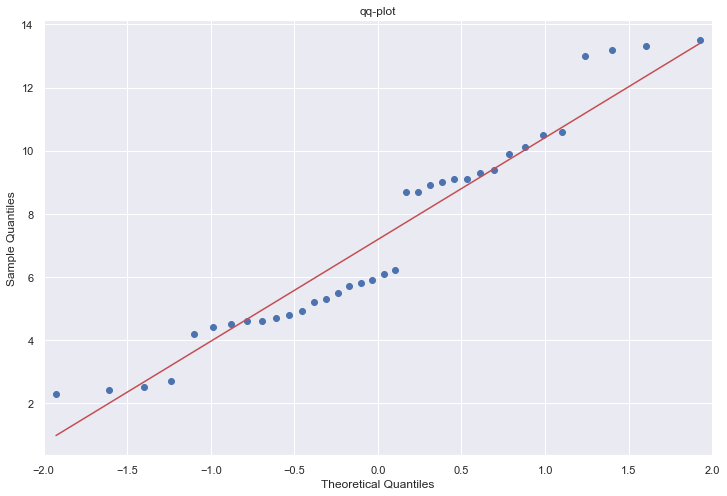

In [75]:
import statsmodels.api as sm

fig = sm.qqplot(data['hours'].values, line='s')
fig.set_figheight(8)
fig.set_figwidth(12)
plt.title("qq-plot")
plt.show()

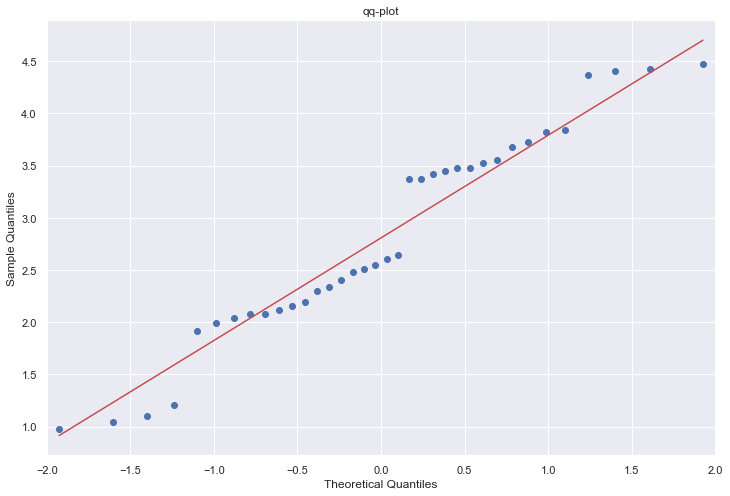

In [74]:
box_cox, _ = boxcox(data['hours'].values)
fig = sm.qqplot(box_cox, line='s')
fig.set_figheight(8)
fig.set_figwidth(12)
plt.title('qq-plot')
plt.show()

Видим, что данные довольно похожи на нормальные, квантили находятся почти на одной прямой
Если применить к ним преобразование бокса-кокса, почти ничего не изменится

### c) График взаимодействия

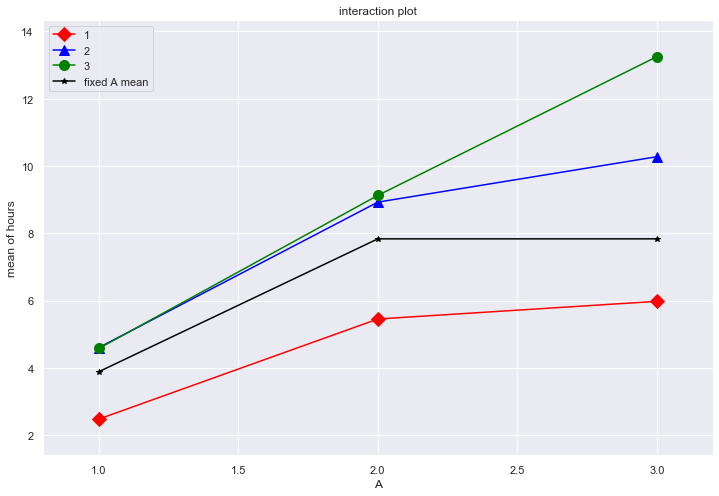

In [82]:
fig = interaction_plot(data['A'], 
                       data['B'], 
                       data['hours'],
                       colors=['red','blue', 'green'], markers=['D','^', 'o'], ms=10)
fig.set_figheight(8)
fig.set_figwidth(12)
a1 = data[data['A'] == 1]['hours'].mean()
a2 = data[data['A'] == 2]['hours'].mean()
a3 = data[data['A'] == 3]['hours'].mean()
plt.plot([1, 2, 3], [a1, a2, a2], color='black', marker='*', label='fixed A mean')
plt.legend()
plt.title("interaction plot");

Посчитаем среднее по маркеру А, сравним с interaction-plot, если взаимодействия нет, то все кривые выглядели бы как черная, но с константными сдвигами. Это не так, значит есть взаимодействие с B

### d) Проверяем взаимодействие факторов с помощью F-теста

In [92]:
formula = 'hours ~ C(A) + C(B) + C(A):C(B)'
model = ols(formula, data).fit()
aov_table = anova_lm(model, typ=2)

def eta_squared(aov):
    aov['eta_sq'] = 'NaN'
    aov['eta_sq'] = aov[:-1]['sum_sq'] / sum(aov['sum_sq'])
    return aov
 
def omega_squared(aov):
    mse = aov['sum_sq'][-1] / aov['df'][-1]
    aov['omega_sq'] = 'NaN'
    aov['omega_sq'] = (aov[:-1]['sum_sq'] - (aov[:-1]['df']*mse))/(sum(aov['sum_sq'])+mse)
    return aov


eta_squared(aov_table)
omega_squared(aov_table)
aov_table

,sum_sq,df,F,PR(>F),eta_sq,omega_sq
C(A),220.020,2.0,1827.858462,1.514043e-29,0.587143,0.586727
C(B),123.660,2.0,1027.329231,3.348751e-26,0.329998,0.329623
C(A):C(B),29.425,4.0,122.226923,6.972083e-17,0.078523,0.077868
Residual,1.625,27.0,NaN,NaN,NaN,NaN


У нас гипотезы: B не влияет на часы, А не влияет на часы, нет взаимодействия между А и B. Для всех p-value < 0.05, значит все отклоняем.


### e) Проверяем наличие эффекта

Для обоих факторов $\eta^2 > 0.26$, что по сему значит сильную выраженность эффекта. При этом по А выраженность эффекта сильнее, чем по B (это можно понять и графически, если посмотреть на interactions plot: эффект по А отражается как разница между средними часами в крайних точках кривой для фиксированной B, а для В то же самое, но для фиксированного А)